In [282]:
import torchvision
import seaborn as sns
from torchvision import transforms
from torchvision.transforms import functional
from sklearn.metrics import accuracy_score
from sklearn import metrics
import numpy as np
from sklearn import utils
import matplotlib.pyplot as plt
from torch.utils import data
import random as rd 
import torch
import torch.nn as nn

### MNIST fully-conected network

In [75]:
trans = transforms.Compose([transforms.ToTensor()])
trans

Compose(
    ToTensor()
)

In [76]:
Train_mnist = torchvision.datasets.MNIST(root = 'mnist',download = False,train = True,transform=trans)
Test_mnist = torchvision.datasets.MNIST(root = 'mnist',download = False,train = False,transform=trans)

In [77]:
print(len(Train_mnist))
print(len(Test_mnist))

60000
10000


In [78]:
Train_mnist.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [80]:
print(len(Train_mnist))
print(len(Test_mnist))
num_cls = len(Train_mnist.classes)
print(num_cls)

60000
10000
10


In [81]:
train_loader = data.DataLoader(dataset = Train_mnist,batch_size = 1,shuffle = True)
print(len(train_loader))

60000


In [82]:
one_val = next(iter(train_loader))

In [83]:
one_tens = one_val[0]
one_tens.shape

torch.Size([1, 1, 28, 28])

In [87]:
mean = torch.zeros(1,)
std = torch.zeros(1,)
all_clsses = []
for pic,cls in iter(train_loader):
    mean += torch.mean(pic,axis = (2,3)).reshape(1)
    std += torch.std(pic,axis = (2,3)).reshape(1)
    all_clsses.append(cls)

In [88]:
mean = mean/len(train_loader)
std = std/len(train_loader)
print(mean,std)

tensor([0.1307]) tensor([0.3015])


In [89]:
cls_weights = utils.compute_class_weight(class_weight='balanced',classes = np.array([_ for _ in range(10)]),y = np.array([int(k) for k in all_clsses]))
cls_weights
#dataset is balanced enough

array([1.01300017, 0.88994364, 1.00704935, 0.97863318, 1.02704553,
       1.10680686, 1.01385603, 0.95770152, 1.02546573, 1.00857287])

In [90]:
#load with normalization
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean = mean,std = std)])
Train_mnist = torchvision.datasets.MNIST(root = 'mnist',download = False,train = True,transform=trans)
Test_mnist = torchvision.datasets.MNIST(root = 'mnist',download = False,train = False,transform=trans)

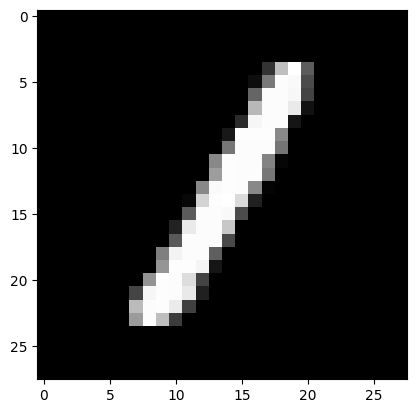

In [101]:
#before normalization
plt.imshow(functional.to_pil_image(one_val[0][0]),cmap = 'gray')

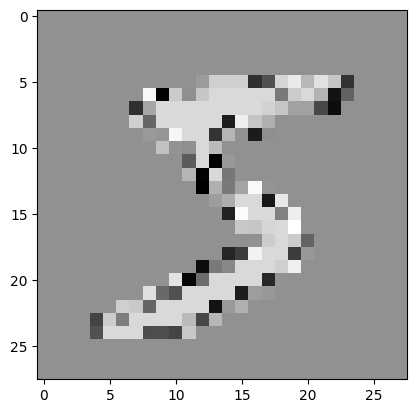

In [105]:
#after normalization
norm_val = next(iter(Train_mnist))
plt.imshow(functional.to_pil_image(norm_val[0][0]),cmap = 'gray')

In [106]:
#Do we really need normalization for mnist?
#probably not

In [207]:
#here is fully connected model
class Mmod(nn.Module):
    def __init__(self):
        super(Mmod,self).__init__()
        self.rel = nn.ReLU()
        self.soft = nn.Softmax(dim = 1)
        self.fc1 = nn.Linear(28*28,200)
        self.fc2 = nn.Linear(200,200)
        self.fc3 = nn.Linear(200,10)
    def forward(self,x):
        y = x.reshape(x.shape[0],-1)
        y = self.rel(self.fc1(y))
        y = self.rel(self.fc2(y))
        y = self.fc3(y)
        y = y.squeeze(dim = 1)
        return y

In [208]:
mmod = Mmod()

In [150]:
train_loader = data.DataLoader(dataset = Train_mnist,shuffle = True,batch_size = 24)
print(len(train_loader))

2500


In [151]:
one_in = next(iter(train_loader))
print(one_in[0].shape)
print(one_in[1].shape)

torch.Size([24, 1, 28, 28])
torch.Size([24])


In [152]:
mmod(one_in[0]).shape

torch.Size([24, 10])

In [153]:
loss = nn.CrossEntropyLoss()
soft = nn.Softmax(dim = 1)
y = torch.tensor([0,0,0])
t1 = torch.randn(3,5)
t1

tensor([[ 0.0554,  1.8978,  0.1114,  0.1214,  1.3757],
        [ 0.8012,  1.4528, -1.5551,  0.7292,  0.2530],
        [ 1.6980,  0.2991, -1.1346,  1.1365, -0.8859]])

In [154]:
soft(t1)

tensor([[0.0759, 0.4788, 0.0802, 0.0810, 0.2841],
        [0.2211, 0.4243, 0.0210, 0.2058, 0.1278],
        [0.5124, 0.1265, 0.0302, 0.2923, 0.0387]])

In [156]:
loss(t1,y)

tensor(1.5855)

In [155]:
-(torch.log(torch.tensor(0.0759))+torch.log(torch.tensor(0.2211))+torch.log(torch.tensor(0.5124)))/3

tensor(1.5854)

In [129]:
# mmod.to(device = 'cuda') cuda is not necessary

In [209]:
epoch = 10
bs = 10
print_every = 1
lr = 0.0005

crit = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params = mmod.parameters(),lr = lr,momentum=0.5)

In [211]:
train_loader = data.DataLoader(dataset = Train_mnist,shuffle = True,batch_size=bs)

In [210]:
test_loader = data.DataLoader(dataset = Test_mnist,shuffle = True,batch_size = 10)

In [212]:
for one_ep in range(epoch):
    train_losses = []
    for X_batch,y_batch in train_loader:
        optim.zero_grad()
        y_pred = mmod(X_batch)
        the_loss = crit(y_pred,y_batch)
        the_loss.backward()
        optim.step()
    if one_ep%print_every == 0:
        train_losses.append(the_loss.item())
        print(f'Epoch #{one_ep+1} | TrainLoss {round(train_losses[-1],5)}')


Epoch #1 | TrainLoss 0.29784
Epoch #2 | TrainLoss 0.05758
Epoch #3 | TrainLoss 0.23941
Epoch #4 | TrainLoss 0.17985
Epoch #5 | TrainLoss 0.0704
Epoch #6 | TrainLoss 0.01033
Epoch #7 | TrainLoss 0.27884
Epoch #8 | TrainLoss 0.01989
Epoch #9 | TrainLoss 0.04925
Epoch #10 | TrainLoss 0.0157


In [215]:
torch.save(mmod.state_dict(),'mnist/mnist_mod1.pth')

In [216]:
def get_test_accuracy(model):
    soft = nn.Softmax(dim = 1)
    accs = []
    with torch.no_grad():
        for X_bat,y_bat in test_loader:
            y_pred = model(X_bat)
            y_pred = soft(y_pred).argmax(dim = 1)
            current_acc = accuracy_score(y_bat.numpy(),y_pred.numpy(),normalize=False)
            accs.append(current_acc)
    return sum(accs)/len(Test_mnist)

In [217]:
get_test_accuracy(mmod)

0.9586

In [189]:
accuracy_score([0,0,0],[0,1,1],normalize=False)

1.0

In [200]:
mmod.load_state_dict(torch.load('mnist/mnist_mod1.pth',weights_only = True))

<All keys matched successfully>

In [240]:
the_pic = functional.to_pil_image(Test_mnist[rd.randint(1,10000)][0]*std+mean)
the_pic

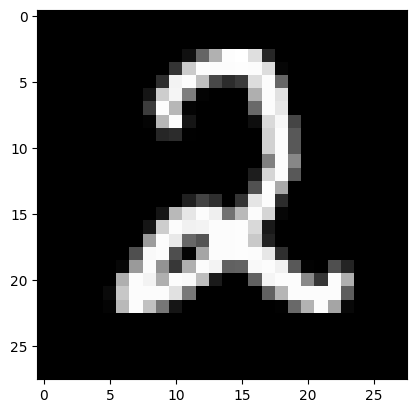

In [241]:
plt.imshow(the_pic,cmap = 'gray')

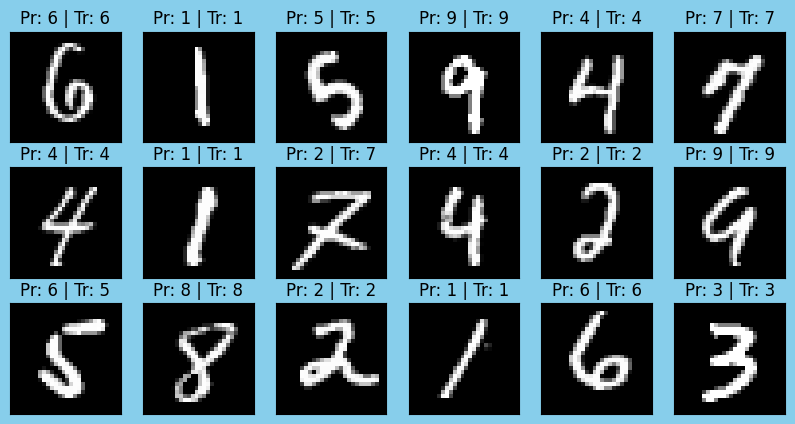

In [428]:
#model inference
main_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
main_figure.tight_layout()
for pic_ind in range(1,19):
    the_ax = main_figure.add_subplot(3,6,pic_ind)
    rand_num = rd.randint(1,10000)
    rand_tens = Test_mnist[rand_num][0]
    rand_true = Test_mnist[rand_num][1]
    soft = nn.Softmax(dim = 1)
    y_pred = mmod(rand_tens)
    y_pred = soft(y_pred).argmax(dim = 1)
    y_pred = int(y_pred.item())
    the_pic = functional.to_pil_image(rand_tens*std+mean)
    the_ax.set_xticks([])
    the_ax.set_yticks([])
    the_ax.imshow(the_pic,cmap = 'gray')
    the_ax.set_title(f'Pr: {y_pred} | Tr: {rand_true}')

In [276]:
y_true = []
y_pred = []
soft = nn.Softmax(dim = 1)
for X_bat,y_bat in test_loader:
    y_mod_pred = soft(mmod(X_bat)).argmax(dim = 1).numpy().tolist()
    y_pred += y_mod_pred
    y_true += y_bat.numpy().tolist()

In [277]:
print(len(y_true))
print(len(y_pred))

10000
10000


In [283]:
conf_mat = metrics.confusion_matrix(y_true=y_true,y_pred = y_pred,labels = [_ for _ in range(10)])
conf_mat

array([[ 966,    0,    1,    2,    0,    4,    5,    1,    1,    0],
       [   0, 1113,    4,    2,    0,    1,    4,    2,    9,    0],
       [   6,    1,  994,    5,    5,    1,    5,    8,    7,    0],
       [   0,    1,   11,  962,    1,   16,    0,    9,    8,    2],
       [   1,    0,    5,    0,  945,    0,    9,    2,    3,   17],
       [  10,    1,    1,    8,    2,  841,    9,    0,   15,    5],
       [   8,    3,    1,    0,    5,    9,  928,    1,    3,    0],
       [   1,    7,   22,    8,    3,    1,    0,  969,    0,   17],
       [   3,    1,    4,   16,    6,    6,    9,    5,  922,    2],
       [   6,    5,    1,   10,   20,    4,    1,    9,    7,  946]])

<Axes: >

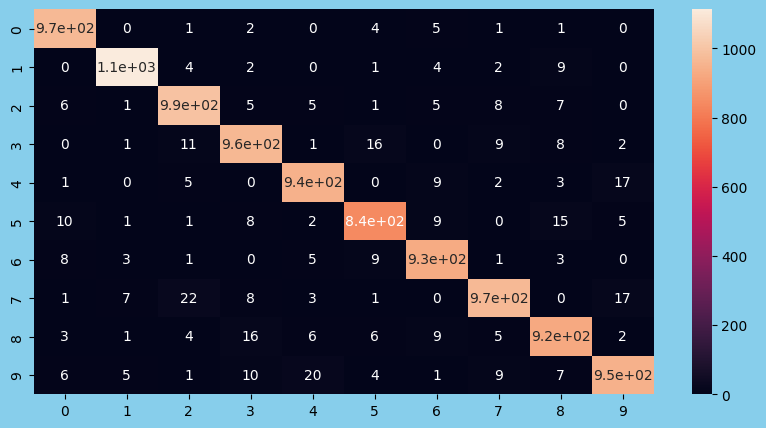

In [287]:
some_fig = plt.figure(figsize=(10,5),facecolor = 'skyblue')
sns.heatmap(conf_mat,annot = True)

[0, 1, 7, 6, 2, 2, 8, 9, 5, 9]